In [2]:
#importing the needed libraries
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
import numpy as np
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, make_scorer, recall_score, f1_score, confusion_matrix, accuracy_score

In [3]:
#reading in the data we will use in the machine learning pipeline, with the top ten features of the method
df = pd.read_excel('pro_accgyro_training_set_10_final.xlsx')
df

,AccZ_Spectral_Variance,AccZ_RMS,AccZ_Spectral_Skewness,AccZ_Spectral_Mean,AccZ_Spectral_Kurtosis,AccZ_Spectral_Flatness,AccZ_Spectral_Entropy,AccZ_Spectral_Crest,AccZ_ZCR,AccZ_Spectral_Rolloff_50,Task_Label,Participant,Classification
0,0.009647,0.001076,0.638555,0.160822,0.348008,0.344127,13.584974,0.000274,0.527733,272.957495,12.0a,10785,0
1,0.009625,0.001083,0.568576,0.162448,0.094564,0.345113,13.588027,0.000262,0.525300,271.757481,12.0b,10785,0
2,0.009874,0.001092,0.607381,0.163459,0.144821,0.345735,13.588096,0.000239,0.524629,271.898173,12.0c,10785,0
3,0.010136,0.001098,0.649654,0.164157,0.329661,0.340929,13.582662,0.000272,0.528676,272.618181,12.0d,10785,0
4,0.009663,0.001078,0.652239,0.161347,0.356853,0.346463,13.588352,0.000289,0.522279,270.532640,12.0e,10785,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,0.012422,0.001175,0.744622,0.178976,0.806176,0.328023,13.575815,0.000298,0.516833,265.476033,85,94527,0
2702,0.113360,0.002589,3.133800,0.329863,13.855738,0.196810,13.331840,0.000672,0.429472,214.338917,87,94527,1
2703,0.027212,0.001323,2.498372,0.202672,11.005391,0.312232,13.469382,0.000559,0.506670,263.117386,89,94527,0
2704,0.060207,0.002128,2.645358,0.300402,14.623167,0.243584,13.466717,0.000794,0.453911,238.066075,91,94527,1


In [4]:
# extracting the features from the DataFrame
features = df.drop(columns=['Classification', 'Participant', 'Task_Label'])

# extracting the Classification (0/1) and participants from the dataframe
target = df['Classification'].values
participants = df['Participant'].values
task = df['Task_Label'].values

# extracting the feature names
feature_names = features.columns.tolist()

# converting the features, target, participants to numpy arrays
features_array = features.values
target_array = target

# creating the dictionary with the needed format to enter into the nested cross-validation
data_dict = {
    'data': features_array,
    'target': target_array,
    'feature_names': feature_names,
    'participants': participants,
    'task': task
}

data_dict

{'data': array([[9.64670000e-03, 1.07550000e-03, 6.38554700e-01, ...,
         2.74400000e-04, 5.27732700e-01, 2.72957495e+02],
        [9.62510000e-03, 1.08310000e-03, 5.68575600e-01, ...,
         2.62400000e-04, 5.25299600e-01, 2.71757481e+02],
        [9.87380000e-03, 1.09150000e-03, 6.07381000e-01, ...,
         2.39100000e-04, 5.24629200e-01, 2.71898173e+02],
        ...,
        [2.72120000e-02, 1.32320000e-03, 2.49837230e+00, ...,
         5.58800000e-04, 5.06670400e-01, 2.63117386e+02],
        [6.02072000e-02, 2.12800000e-03, 2.64535850e+00, ...,
         7.94300000e-04, 4.53911200e-01, 2.38066075e+02],
        [1.43461000e-02, 1.19270000e-03, 1.18200380e+00, ...,
         3.93000000e-04, 5.17238800e-01, 2.65831899e+02]]),
 'target': array([0, 0, 0, ..., 0, 1, 0]),
 'feature_names': ['AccZ_Spectral_Variance',
  'AccZ_RMS',
  'AccZ_Spectral_Skewness',
  'AccZ_Spectral_Mean',
  'AccZ_Spectral_Kurtosis',
  'AccZ_Spectral_Flatness',
  'AccZ_Spectral_Entropy',
  'AccZ_Spectral_Cre

In [4]:
#running the nested cross-validation for the Accelerometer method using Gradient Boosting

from sklearn.metrics import accuracy_score, precision_score, recall_score

# random seed for reproducibility
random_seed = 1
np.random.seed(random_seed)

X = data_dict['data']
Y = data_dict['target']
groups = data_dict['participants']

# setting up the parameter grid: the combinations of these will be tried out for ever outer loop's inner loop
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.9, 1.0],  
    'max_depth': [3, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}


gbc = GradientBoostingClassifier(random_state=random_seed)

logo = LeaveOneGroupOut()


# defining the techniques to use for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=1)
outer_cv = logo.split(X, Y, groups)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, average='weighted')
}

# performing nested cross-validation
clf = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=inner_cv)
cv_dic = cross_validate(clf, X, Y, cv=outer_cv, scoring=scoring, return_estimator=True, return_train_score=False)
mean_acc_score = cv_dic['test_accuracy'].mean()
mean_prec_score = cv_dic['test_precision'].mean()
mean_rec_score = cv_dic['test_recall'].mean()
mean_f1_score = cv_dic['test_f1_score'].mean()
mean_roc_auc = cv_dic['test_roc_auc'].mean()  # Mean ROC AUC score


print('nested_accuracy_scores:   ', cv_dic['test_accuracy'])
print('mean score:            {0:.4f}'.format(mean_acc_score))

print('nested_precision_scores:   ', cv_dic['test_precision'])
print('mean score:            {0:.4f}'.format(mean_prec_score))

print('nested_recall_scores:   ', cv_dic['test_recall'])
print('mean score:            {0:.4f}'.format(mean_rec_score))

print('nested_f1_scores:   ', cv_dic['test_f1_score'])
print('mean score:            {0:.4f}'.format(mean_f1_score))

print('nested_roc_auc_scores:   ', cv_dic['test_roc_auc'])
print('mean score:            {0:.4f}'.format(mean_roc_auc))

nested_accuracy_scores:    [0.92424242 1.         0.98484848 0.98484848 1.         1.
 0.87878788 1.         0.96969697 1.         1.         1.
 0.98484848 0.98484848 1.         1.         0.96969697 0.96969697
 1.         1.         1.         0.90909091 1.         1.
 1.         1.         1.         0.98484848 0.83333333 0.98484848
 1.         1.         1.         0.98484848 1.         0.98484848
 1.         0.87878788 0.8030303  1.         1.        ]
mean score:            0.9760
nested_precision_scores:    [0.93230174 1.         0.98520085 0.98520085 1.         1.
 0.89747475 1.         0.97107438 1.         1.         1.
 0.98520085 0.98545455 1.         1.         0.97202797 0.97107438
 1.         1.         1.         0.92045455 1.         1.
 1.         1.         1.         0.98545455 0.88571429 0.98545455
 1.         1.         1.         0.98545455 1.         0.98520085
 1.         0.89818182 0.80154426 1.         1.        ]
mean score:            0.9788
nested_recall_s

In [5]:
sensitivity_scores = []
specificity_scores = []

# iteration over the outer folds to calculate average sensitivity and specificity
for i, (train_index, test_index) in enumerate(logo.split(X, Y, groups)):
    print(f"Fold {i + 1}:")

    # getting the trained estimator for the present fold
    estimator = cv_dic['estimator'][i]
    
    # predicting on the test set
    y_pred = estimator.predict(X[test_index])
    
    # creating confusion matrix
    tn, fp, fn, tp = confusion_matrix(Y[test_index], y_pred).ravel()
    
    # calculating the sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("=" * 30)
    
    # store the sensitivity and specificity scores
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

    
    # calculate and print the averages of the sensitivity and specificity scores previously calculated
average_sensitivity = np.mean(sensitivity_scores)
average_specificity = np.mean(specificity_scores)

print("Average Sensitivity:", average_sensitivity)
print("Average Specificity:", average_specificity)

Fold 1:
Sensitivity: 0.7917
Specificity: 1.0000
Fold 2:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 3:
Sensitivity: 0.9583
Specificity: 1.0000
Fold 4:
Sensitivity: 0.9583
Specificity: 1.0000
Fold 5:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 6:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 7:
Sensitivity: 0.9583
Specificity: 0.8333
Fold 8:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 9:
Sensitivity: 0.9167
Specificity: 1.0000
Fold 10:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 11:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 12:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 13:
Sensitivity: 0.9583
Specificity: 1.0000
Fold 14:
Sensitivity: 1.0000
Specificity: 0.9762
Fold 15:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 16:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 17:
Sensitivity: 1.0000
Specificity: 0.9524
Fold 18:
Sensitivity: 0.9167
Specificity: 1.0000
Fold 19:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 20:
Sensitivity: 1.0000
Specificity: 1.0000
Fold 21:
Sensitivity: 1.0000


In [6]:
#print all performance scores that might be of interest
import scipy.stats

def calculate_stats(data):
    mean = np.mean(data)
    sd = np.std(data, ddof=1)  # using sample standard deviation (N-1)
    ci = scipy.stats.norm.interval(0.95, loc=mean, scale=sd/np.sqrt(len(data)))
    min_val = np.min(data)
    max_val = np.max(data)
    return mean, sd, ci, min_val, max_val

keys = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc', 'sensitivity_scores', 'specificity_scores']

for key in keys:
    if key in cv_dic:
        data = cv_dic[key]
    elif key == 'sensitivity_scores':
        data = sensitivity_scores
    elif key == 'specificity_scores':
        data = specificity_scores

    stats = calculate_stats(data)
    print(f"{key}: Mean={stats[0]}, SD={stats[1]}, 95% CI={stats[2]}, Min={stats[3]}, Max={stats[4]}")

test_accuracy: Mean=0.9759793052475979, SD=0.047670193111104264, 95% CI=(0.9613876999359864, 0.9905709105592094), Min=0.803030303030303, Max=1.0
test_precision: Mean=0.9788407242453911, SD=0.04184992646283923, 95% CI=(0.9660306731545036, 0.9916507753362787), Min=0.8015442595826823, Max=1.0
test_recall: Mean=0.9759793052475979, SD=0.047670193111104264, 95% CI=(0.9613876999359864, 0.9905709105592094), Min=0.803030303030303, Max=1.0
test_f1_score: Mean=0.9738272807091445, SD=0.05161699733959114, 95% CI=(0.9580275785599545, 0.9896269828583345), Min=0.7852315394242804, Max=1.0
test_roc_auc: Mean=0.9925353271389858, SD=0.03175880804172842, 95% CI=(0.9828141164228458, 1.002256537855126), Min=0.8030753968253969, Max=1.0
sensitivity_scores: Mean=0.9644308943089432, SD=0.08258044037658875, 95% CI=(0.9391534386538797, 0.9897083499640068), Min=0.6666666666666666, Max=1.0
specificity_scores: Mean=0.9825783972125435, SD=0.05217067920602621, 95% CI=(0.9666092158408887, 0.9985475785841983), Min=0.7380

In [7]:
# IF this is the best-performing nested CV for the method: print best hyperparameters for each outer loop
for fold_idx, estimator in enumerate(cv_dic['estimator']):
    print(f'Fold {fold_idx + 1} - Best hyperparameters: {estimator.best_params_}')


Fold 1 - Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}
Fold 2 - Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}
Fold 3 - Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
Fold 4 - Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}
Fold 5 - Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 0.9}
Fold 6 - Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': None, 'min_sampl

In [8]:
# IF this is the best-performing nested CV for the method: print mode of hyperparameters

from collections import defaultdict, Counter

# initialize a dictionary to contain all hyperparameters and their values across loops
hyperparameters = defaultdict(list)

# extracting hyperparameters of each outer loop
for estimator in cv_dic['estimator']:
    for param, value in estimator.best_params_.items():
        hyperparameters[param].append(value)

# count the most frequent value for each hyperparameter
for param, values in hyperparameters.items():
    most_common_value, count = Counter(values).most_common(1)[0]  # Get the most frequent value
    print(f'Hyperparameter: {param} - Most frequent value: {most_common_value} (Count: {count})')


Hyperparameter: learning_rate - Most frequent value: 0.1 (Count: 41)
Hyperparameter: max_depth - Most frequent value: 4 (Count: 28)
Hyperparameter: max_features - Most frequent value: sqrt (Count: 27)
Hyperparameter: min_samples_leaf - Most frequent value: 1 (Count: 29)
Hyperparameter: min_samples_split - Most frequent value: 2 (Count: 27)
Hyperparameter: n_estimators - Most frequent value: 200 (Count: 39)
Hyperparameter: subsample - Most frequent value: 1.0 (Count: 24)


In [ ]:
#After acknowleding Gradient Boosting performed the best in the nested CVs for the Acc-Gyro method,
#we continue below with training a final best model for this method

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

#X and Y are also defined previously but let's recall
X = data_dict['data']
Y = data_dict['target']

# specifying our hyperparameters (modes taken from the outer loops of the best performing nested CV)
hyperparameters = {
    'learning_rate': 0.1,  
    'max_depth': 4, 
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200,
    'subsample': 1.0  
}

# calling the classifier
gbc_model_acc = GradientBoostingClassifier(**hyperparameters)

# training a model
gbc_model_acc.fit(X, Y)



GradientBoostingClassifier(max_depth=4, max_features='sqrt', n_estimators=200)

In [29]:
#Let's already save the trained model for later deployment (so future users don't need to retrain the model)

import pickle

with open('acc_model.pkl', 'wb') as file:
    pickle.dump(gbc_model_acc, file)

print("Model saved.")


Model saved.


In [6]:
df_new = pd.read_excel('pro_accgyro_testing_set_10_final.xlsx')
# it is essential to rearrange columns in the needed order
ordered_columns = [
    'AccZ_Spectral_Variance', 'AccZ_RMS', 'AccZ_Spectral_Skewness', 'AccZ_Spectral_Mean',
    'AccZ_Spectral_Kurtosis', 'AccZ_Spectral_Flatness', 'AccZ_Spectral_Entropy', 'AccZ_Spectral_Crest',
    'AccZ_ZCR', 'AccZ_Spectral_Rolloff_50', 'Task_Label', 'Participant', 'Classification'
]

# Reorder the columns in the DataFrame
df_new = df_new[ordered_columns]

df_new

,AccZ_Spectral_Variance,AccZ_RMS,AccZ_Spectral_Skewness,AccZ_Spectral_Mean,AccZ_Spectral_Kurtosis,AccZ_Spectral_Flatness,AccZ_Spectral_Entropy,AccZ_Spectral_Crest,AccZ_ZCR,AccZ_Spectral_Rolloff_50,Task_Label,Participant,Classification
0,0.009924,0.001086,0.618716,0.162233,0.233627,0.345091,13.580845,0.000250,0.525937,270.383673,12.0a,11737,0
1,0.009580,0.001074,0.594537,0.160560,0.191422,0.346406,13.583686,0.000302,0.526251,271.947828,12.0b,11737,0
2,0.009722,0.001087,0.580747,0.162852,0.256515,0.351370,13.585993,0.000275,0.526177,271.004370,12.0c,11737,0
3,0.009840,0.001092,0.557611,0.163549,0.071911,0.353272,13.585315,0.000275,0.524331,269.440215,12.0d,11737,0
4,0.009636,0.001082,0.566902,0.162177,0.129054,0.352633,13.587720,0.000263,0.524919,271.873345,12.0e,11737,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0.013300,0.001277,0.613998,0.191686,0.288317,0.345221,13.595142,0.000302,0.518157,267.727092,85,99994,0
656,0.022612,0.001523,1.240583,0.227945,3.747581,0.321967,13.559418,0.000471,0.503476,257.969743,87,99994,1
657,0.013624,0.001278,0.635333,0.191160,0.220795,0.336127,13.590406,0.000267,0.523678,270.391949,89,99994,0
658,0.021312,0.001474,1.633116,0.213965,6.331911,0.316754,13.551413,0.000454,0.498759,255.453853,91,99994,1


In [7]:
import pandas as pd
import numpy as np

#we define our dictionary that will enable us to test the final best method

#drop ALL columns that is not a feature
features_new = df_new.drop(columns=['Classification', 'Participant', 'Task_Label'])

# extracting the target (Classification) and participants
target_new = df_new['Classification'].values
participants_new = df_new['Participant'].values
task_new = df_new['Task_Label'].values

# extracting the feature names
feature_names_new = features_new.columns.tolist()

# converting the features, target, and participants to numpy arrays
features_array_new = features_new.values
target_array_new = target_new

# creating the dictionary with the needed format
data_dict_new = {
    'data': features_array_new,
    'target': target_array_new,
    'feature_names': feature_names_new,
    'participants': participants_new,
    'task': task_new
}

data_dict_new


{'data': array([[9.92430000e-03, 1.08630000e-03, 6.18715700e-01, ...,
         2.50000000e-04, 5.25936800e-01, 2.70383673e+02],
        [9.57980000e-03, 1.07370000e-03, 5.94536800e-01, ...,
         3.01500000e-04, 5.26251300e-01, 2.71947828e+02],
        [9.72180000e-03, 1.08650000e-03, 5.80746700e-01, ...,
         2.74700000e-04, 5.26176800e-01, 2.71004370e+02],
        ...,
        [1.36243000e-02, 1.27790000e-03, 6.35332700e-01, ...,
         2.66900000e-04, 5.23677500e-01, 2.70391949e+02],
        [2.13118000e-02, 1.47430000e-03, 1.63311580e+00, ...,
         4.54400000e-04, 4.98758600e-01, 2.55453853e+02],
        [1.35174000e-02, 1.28540000e-03, 5.74253500e-01, ...,
         2.90200000e-04, 5.23338200e-01, 2.68124338e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0,

In [8]:
X_test = data_dict_new['data']
Y_test = data_dict_new['target']
groups_test = data_dict_new['participants'] # we do not group while testing, but just saving the variable

In [16]:
#getting the training and testing accuracies

train_acc = accuracy_score(y_true=Y, y_pred=gbc_model_acc.predict(X))
test_acc = accuracy_score(y_true=Y_test, y_pred=gbc_model_acc.predict(X_test))

print('Training Accuracy: %.4f%%' % (100 * train_acc))
print('Test Accuracy: %.4f%%' % (100 * test_acc))

Training Accuracy: 100.0000%
Test Accuracy: 98.4848%


In [17]:
#calculating the AUC
predicted_probs = gbc_model_acc.predict_proba(X_test)[:, 1]  # probability of the positive class
auc = roc_auc_score(Y_test, predicted_probs)
auc

0.9960416666666667

In [18]:
predicted_probs #these probabilities will be pasted into the R script to run the DeLong's test

array([1.27371854e-04, 1.67307600e-04, 2.16240684e-04, 1.07422074e-04,
       8.38048447e-05, 1.05421640e-04, 2.68443132e-05, 4.90956905e-05,
       8.27917508e-05, 4.13142937e-04, 2.14513651e-05, 4.37437693e-05,
       4.85672658e-05, 7.93618208e-05, 2.20106250e-05, 6.08383628e-05,
       6.83075771e-05, 9.91248649e-05, 9.98364526e-01, 9.97778369e-01,
       9.98499106e-01, 1.26609748e-04, 1.02890173e-04, 8.48564763e-05,
       9.99879633e-01, 9.99879630e-01, 9.99866996e-01, 5.51281760e-05,
       3.46385938e-05, 1.96869784e-05, 9.99553526e-01, 9.99514569e-01,
       9.99697586e-01, 4.55304304e-05, 4.34554654e-05, 4.89405234e-05,
       9.96640909e-01, 7.75136499e-05, 9.98212060e-01, 1.43574045e-04,
       9.96848829e-01, 7.54229361e-05, 9.99687439e-01, 2.64079257e-04,
       9.99687439e-01, 3.03204649e-05, 9.99599825e-01, 1.96869784e-05,
       9.99608309e-01, 9.99593179e-01, 2.23792372e-04, 7.08476482e-05,
       9.99550984e-01, 1.27024116e-04, 9.99698513e-01, 9.99833189e-01,
      

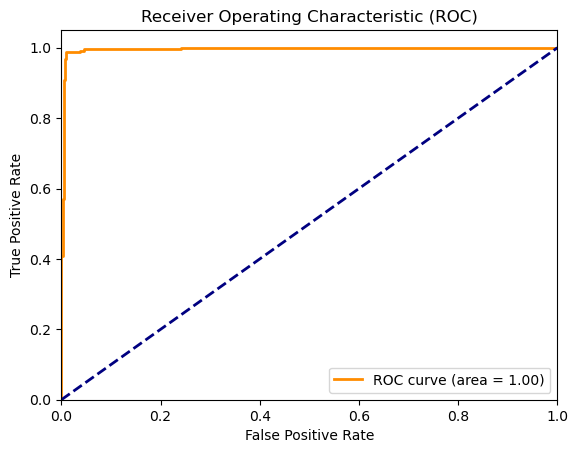

In [19]:
#calculating and plotting the ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(Y_test, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
#here, we will form confusion matrices, and calculate the sensitivity and specificity for the test set

train_preds = gbc_model_acc.predict(X)
test_preds = gbc_model_acc.predict(X_test)

# making the confusion matrix for train set
conf_matrix_train = confusion_matrix(y_true=Y, y_pred=train_preds)

# making the confusion matric for test set
conf_matrix_test = confusion_matrix(y_true=Y_test, y_pred=test_preds)

# compute specificity and sensitivity via confusion matrix
specificity_train = conf_matrix_train[0, 0] / (conf_matrix_train[0, 0] + conf_matrix_train[0, 1])
sensitivity_train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 0] + conf_matrix_train[1, 1])

specificity_test = conf_matrix_test[0, 0] / (conf_matrix_test[0, 0] + conf_matrix_test[0, 1])
sensitivity_test = conf_matrix_test[1, 1] / (conf_matrix_test[1, 0] + conf_matrix_test[1, 1])

# computing accuracy (was also computed previously)
train_acc = accuracy_score(y_true=Y, y_pred=train_preds)
test_acc = accuracy_score(y_true=Y_test, y_pred=test_preds)

# printing the results
print('Confusion Matrix - Training Data:\n', conf_matrix_train)
print('Specificity - Training Data: %.4f' % specificity_train)
print('Sensitivity - Training Data: %.4f' % sensitivity_train)
print('Training Accuracy: %.4f%%' % (100 * train_acc))

print('\nConfusion Matrix - Test Data:\n', conf_matrix_test)
print('Specificity - Test Data: %.4f' % specificity_test)
print('Sensitivity - Test Data: %.4f' % sensitivity_test)
print('Test Accuracy: %.4f%%' % (100 * test_acc))


Confusion Matrix - Training Data:
 [[1722    0]
 [   0  984]]
Specificity - Training Data: 1.0000
Sensitivity - Training Data: 1.0000
Training Accuracy: 100.0000%

Confusion Matrix - Test Data:
 [[413   7]
 [  3 237]]
Specificity - Test Data: 0.9833
Sensitivity - Test Data: 0.9875
Test Accuracy: 98.4848%


In [23]:
test_preds #printing a list of predicted classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,

In [24]:
from sklearn.metrics import classification_report

#using the classification report function to also check the F1 score
train_preds = gbc_model_acc.predict(X)
test_preds = gbc_model_acc.predict(X_test)

print("Classification Report - Training Data:\n")
print(classification_report(y_true=Y, y_pred=train_preds))

print("Classification Report - Test Data:\n")
print(classification_report(y_true=Y_test, y_pred=test_preds))


Classification Report - Training Data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1722
           1       1.00      1.00      1.00       984

    accuracy                           1.00      2706
   macro avg       1.00      1.00      1.00      2706
weighted avg       1.00      1.00      1.00      2706

Classification Report - Test Data:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       420
           1       0.97      0.99      0.98       240

    accuracy                           0.98       660
   macro avg       0.98      0.99      0.98       660
weighted avg       0.98      0.98      0.98       660



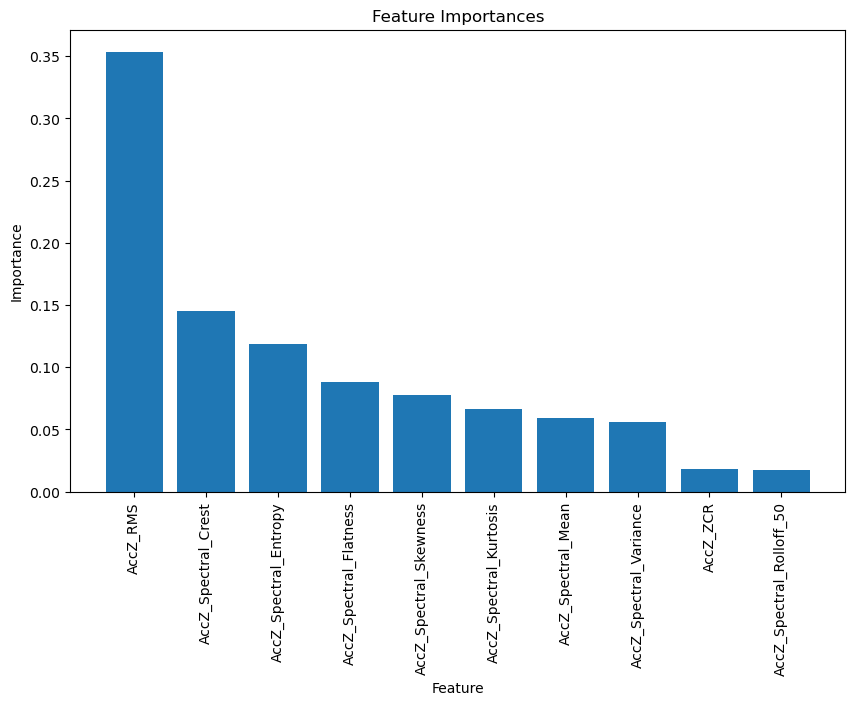

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# get the feature names from the data_dict
feature_names = data_dict['feature_names']

# get feature importances from the model
importances = gbc_model_acc.feature_importances_

# sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[sorted_indices], align='center')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
